# Importing Libraries

In [3]:
# !pip install torch_snippets

In [57]:
import os
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch_snippets import *
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader


%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Downloading data

In [5]:
if not os.path.exists('cell_images'):
  !pip install -U -q torch_snippets
  !wget -q ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
  !unzip -qq cell_images.zip
  !rm cell_images.zip

In [6]:
id2int = {'Parasitized': 0, 'Uninfected': 1}

# Defining Data Augmentation

In [7]:
trn_tfms = T.Compose([
                      T.ToPILImage(),
                      T.Resize(128),
                      T.CenterCrop(128),
                      T.ColorJitter(brightness=(0.95,1.05),
                                    contrast=(0.95,1.05),
                                    saturation=(0.95,1.05),
                                    hue=0.05),
                      T.RandomAffine(5, translate=(0.01,0.1)),
                      T.ToTensor(),
                      T.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5]),
])

In [8]:
val_tfms = T.Compose([
                      T.ToPILImage(),
                      T.Resize(128),
                      T.CenterCrop(128),
                      T.ToTensor(),
                      T.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5]),
])

# Creating dataset and dataloader

In [9]:
class MalariaImages(Dataset):

  def __init__(self, files, transform=None):
    super(MalariaImages, self).__init__()
    self.files = files
    self.transform = transform
    logger.info(len(self))

  def __len__(self):
    return len(self.files)

  def __getitem__(self, item):
    fpath = self.files[item]
    label = fname(parent(fpath))
    img = read(fpath, 1)
    return img, label

  def choose(self):
    return self[randint(len(self))]

  def collate_fn(self, batch):
    _imgs, classes = list(zip(*batch))
    if self.transform:
      imgs = [self.transform(img)[None] for img in _imgs]
    
    classes = [torch.tensor([id2int[label]]) for label in classes]
    imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]

    return imgs, classes, _imgs

In [10]:
all_files = Glob('cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

2021-06-05 20:37:11.902 | INFO     | __main__:<module>:1 - 27558 files found at cell_images/*/*.png


In [11]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(all_files, random_state=1)

train_ds = MalariaImages(train_files, transform=trn_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, 
                      collate_fn=train_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False,
                    collate_fn=val_ds.collate_fn)

2021-06-05 20:37:11.929 | INFO     | __main__:__init__:7 - 20668
2021-06-05 20:37:11.930 | INFO     | __main__:__init__:7 - 6890


# Creating model

In [18]:
def convBlock(ni, no):
  return nn.Sequential(
          nn.Dropout(0.2),
          nn.Conv2d(ni, no, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(no),
          nn.MaxPool2d(2),
        )

In [19]:
class MalariaClassifier(nn.Module):

  def __init__(self):
    super(MalariaClassifier, self).__init__()
    self.model = nn.Sequential(
        convBlock(3, 64),
        convBlock(64, 64),
        convBlock(64, 128),
        convBlock(128, 256),
        convBlock(256, 512),
        convBlock(512, 64),
        nn.Flatten(),
        nn.Linear(256, 256),
        nn.Dropout(0.2),
        nn.ReLU(inplace=True),
        nn.Linear(256, len(id2int))
    )

    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, x):
    return self.model(x)

  def compute_metrics(self, preds, targets):
    loss = self.loss_fn(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return loss, acc

# Creating training loop

In [20]:
def train_batch(model, data, optimizer, criterion):
  model.train()
  ims, labels, _ = data
  preds = model(ims)
  optimizer.zero_grad()
  loss, acc = criterion(preds, labels)
  loss.backward()
  optimizer.step()
  return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
  model.eval()
  ims, labels, _ = data
  preds = model(ims)
  loss, acc = criterion(preds, labels)
  return loss.item(), acc.item()

In [21]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training the model

In [ ]:
n_epochs = 2

log = Report(n_epochs)

In [22]:
for epoch in range(n_epochs):
  N = len(train_dl)
  for bx, data in enumerate(train_dl):
    loss, acc = train_batch(model, data, optimizer, criterion)
    log.record(epoch + (bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')
  
  N = len(val_dl)
  for bx, data in enumerate(val_dl):
    loss, acc = validate_batch(model, data, criterion)
    log.record(epoch + (bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

  log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 0.244	trn_acc: 0.906	val_loss: 0.232	val_acc: 0.927	(121.02s - 121.02s remaining)
EPOCH: 2.000	trn_loss: 0.168	trn_acc: 0.946	val_loss: 0.163	val_acc: 0.945	(240.76s - 0.00s remaining)


# Selecting the model till the required layer for CAMs

In [33]:
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

# Defining grad CAM function

In [95]:
def im2gradCAM(x):

  model.eval()
  logits = model(x)
  heatmaps = None
  activations = im2fmap(x)

  pred = logits.max(-1)[-1]

  model.zero_grad()

  logits[0, pred].backward(retain_graph=True)

  pooled_grads = model.model[-7][1].weight.grad.data.mean((0,2,3))

  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_grads[i]

  heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
  
  return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [102]:
SZ = 128

def upsampleHeatmap(map, img):
  m, M = map.min(), map.max()
  map = 255 * ((map-m) / (M-m))
  map = np.uint8(map)
  map = cv2.resize(map, (SZ, SZ))
  map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
  map = np.uint8(map)
  map = np.uint8(map*0.7 + img*0.3)
  return map

# Visualizing CAMs

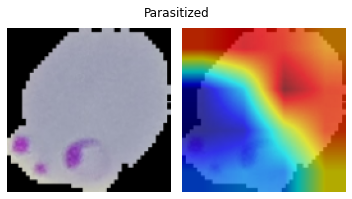

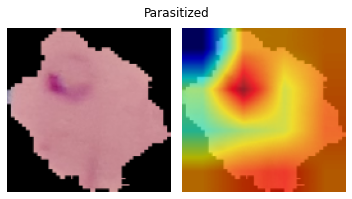

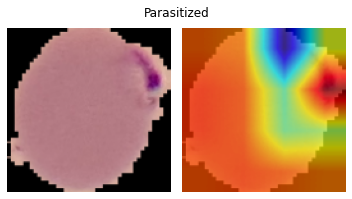

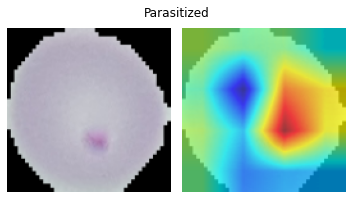

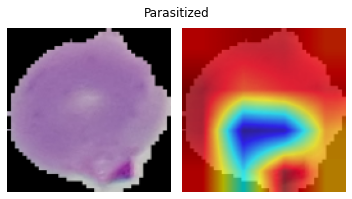

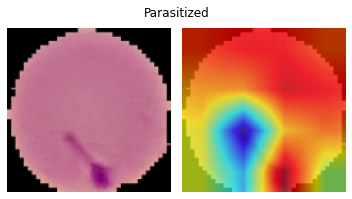

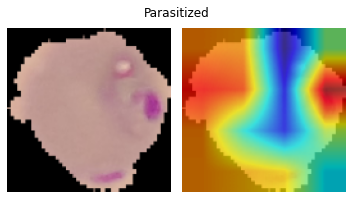

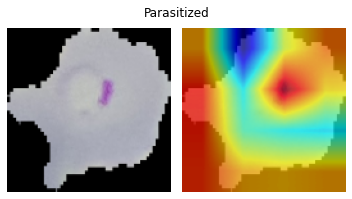

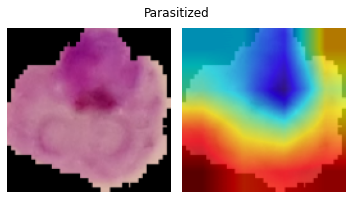

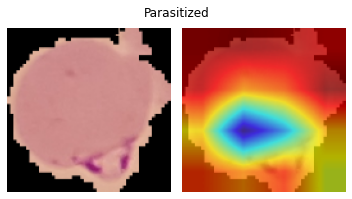

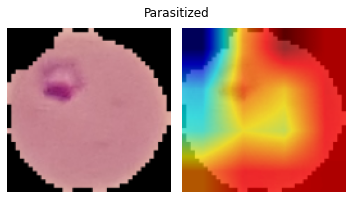

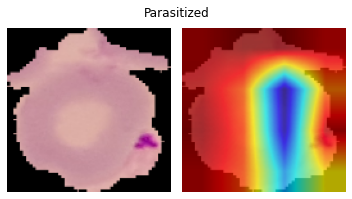

In [107]:
N = 20

_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True,
                      collate_fn=val_ds.collate_fn)

x,y,z = next(iter(_val_dl))

for i in range(N):
  image = resize(z[i], SZ)
  heatmap, pred = im2gradCAM(x[i:i+1])

  if(pred=='Uninfected'):
    continue
    
  heatmap = upsampleHeatmap(heatmap, image)
  subplots([image, heatmap], nc=2, figsize=(5,3),
            suptitle=pred)

# Saving the model

In [108]:
torch.save(model.state_dict(), './Malaria_model.bin')